<img style="float: left;" src="../images/logo.png" width="400"/>

# INTRODUCTION TO ACTVICE FIRE PRODUCT  

this code aims at showing you where to find GFAS data and also have some understanding of the data used in the calculation.

As an example we will focus here on CO emissions. 
As a recall the fire emission (E_CO for CO) calculation based on the FRP (as done in GFAS) reads like:

```
E_CO = DM * EF_CO                               (Equation 1)
```

where the burning dry matter (DM) is

```
DM = Converstion_factor * FRE                    (Equation 2)
```


and FRE (Fire Radiative Power) is the time integration of Fire Radiative Power (FRP). See [this Copernicus page](https://www.copernicus.eu/en/access-data/copernicus-services-catalogue/satellite-fire-radiative-power) for a presentation of FRE and FRP satellite products. 

Refer to [Kaiser et al 2012](https://bg.copernicus.org/articles/9/527/2012/) for GFAS algoritgm. 

To run this notebook you will need to get data that  
- are available [here]() **TO ADD**
- or if you are on andromeda  you can set you directory data to `/data/IMFSE/FBM_unit05/Emission/GFAS`


we go through the different terms of the above equation in what follows

## 1. To go through the data

In this section we are going to through the terms of equation 1 and 2 and show you how to compute them.

### 1.1. import library and set variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
#from netCDF4 import Dataset
import rioxarray
import geopandas as gpd
import scipy
import shapely
import datetime
from scipy.stats import gaussian_kde
from haversine import haversine, Unit
import xarray as xr
import importlib
from rasterio.transform import from_origin
from rasterio.features import geometry_mask
%matplotlib inline

#homebrewed 
import haversine2Da 

In [2]:
directory    = '/data/IMFSE/FireBehaviourModelling/Emission/GFAS/'

### 1.2 Read in Dominant Land cover and Converstion Factor

The conversion factor are static and dependent of the land cover class.

In [3]:
landCover = xr.open_dataset(directory+'GFED3_dominantBurningLC_version11112010_GAPFILLED.r720x360JUEL_EXTPEATOS.nc')
landCover = landCover.rename({"lat": "latitude"})
landCover = landCover.rename({"lon": "longitude"})
landCover

<xarray.Dataset> Size: 1MB
Dimensions:            (longitude: 720, latitude: 360, time: 1)
Coordinates:
  * longitude          (longitude) float64 6kB 0.25 0.75 1.25 ... 359.2 359.8
  * latitude           (latitude) float64 3kB -89.75 -89.25 ... 89.25 89.75
  * time               (time) datetime64[ns] 8B 2000-01-01
Data variables:
    dominantBurningLC  (time, latitude, longitude) float32 1MB ...
Attributes:
    CDI:          Climate Data Interface version 1.4.1
    Conventions:  CF-1.0
    history:      "Created from original data by Angelika Heil using GFED3_do...
    institution:  Research Center Juelich, IEK-8,Germany
    datasetname:  Dominant burning source map related to the Global Fire Emis...
    references:   van der Werf et al. (2010) ACP, extented by peat and peaty ...
    title:        GFASv1 Dominant Burning Land Cover Type (modified GFED3)
    comment:      Dominant burning source map related to the Global Fire Emis...
    contact:      a.heil@fz-juelich.de
    CDO:          Climate Data Operators version 1.4.1 (http://www.mpimet.mpg...
    source:       This dataset has been prepared from the ascii data obtained...

In [4]:
burninLC = landCover['dominantBurningLC'].isel(time=0)
burninLC

<xarray.DataArray 'dominantBurningLC' (latitude: 360, longitude: 720)> Size: 1MB
[259200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * latitude   (latitude) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    time       datetime64[ns] 8B 2000-01-01
Attributes:
    long_name:    1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    units:        unitless
    description:  1=SA,2=SAOS,3=AG,4=AGOS,5=TF,6=PEAT,7=EF,8=EFOS
    unit:         1

shape is (360, 720)


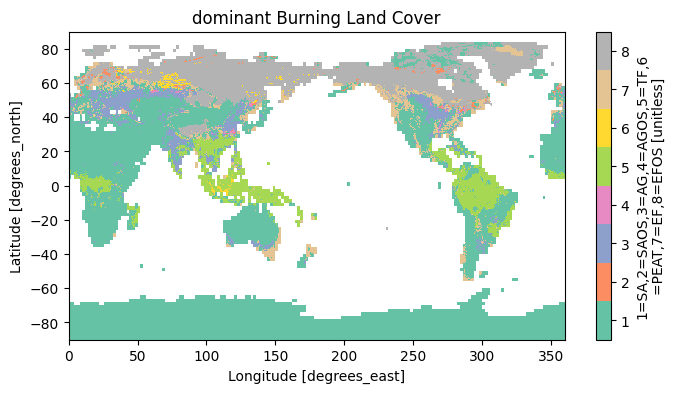

In [5]:
plt.figure(figsize=(8,4))
cmap = plt.get_cmap('Set2', np.unique(burninLC).shape[0]-1) # remove 0
c=burninLC.where(burninLC!=0).plot(cmap=cmap,vmin=0.5, vmax=8.5, cbar_kwargs={'ticks':range(9)} )
plt.title('dominant Burning Land Cover')
print( 'shape is', burninLC.shape)
#plt.colorbar(c, ticks=range(9),)

conversion factor and area named are in `conversionFactor.txt`

In [6]:
LCidx = pd.read_csv(directory+'conversionFactor.txt')
LCidx.columns = LCidx.columns.str.strip()
LCidx.index += 1
LCidx

,land_cover,class_abbrev,conv_factor,fuel_type,
1,savannah,SA,0.78,SA,
2,savannah_with_organic_soil,SAOS,0.26,SA,
3,agriculture,AG,0.29,AG,
4,agriculture_with_organic_soil,AGOS,0.13,AG,
5,tropical_forest,TF,0.96,TF,
6,peat,PEAT,5.87,PEAT,
7,extratropical_forest,EF,0.49,EF,
8,extratropical_forest_with_organic_soil,EFOS,1.55,EF,


Therefore, form table above, if you know you land covcer form the dominant land cover map, then you know the conversion factor.

### 1.3 Read in Emission Factors

In [7]:
data_EF = pd.read_csv(directory+'/EF_kaiser2012.csv', header=0).iloc[:, :-1] #remove last column
data_EF

,Species,SA,TF,EF,AG,PEAT
0,CO2,1646.000,1626.000,1572.000,1308.000,1703.000
1,CO,61.000,101.000,106.000,92.000,210.000
2,CH4,2.200,6.600,4.800,8.400,20.800
3,NMHC,3.400,7.000,5.700,9.900,12.100
4,H2,0.980,3.500,1.800,2.700,3.500
5,NOx,2.100,2.300,3.400,2.300,1.000
6,N2O,0.210,0.240,0.260,0.100,0.240
7,PM2p,4.900,9.100,13.800,8.300,9.100
8,TPM,8.500,11.800,17.600,12.400,11.800
9,TC,3.700,6.000,8.300,3.700,6.100


### 1.4 Read in FRP and FRE

This is the most demanding step of the computation.    
FRP is coming from satellite observation. In the case of GFAS, it is still based on the MODIS sensor. A schematic view of the data processing to go from satellite observation to FRP and FRE needed in GFAS equation is listed below:
- satellite detects a fire and tag a pixel of the image sensor as a hot spot. It corresponds to a vector data (a point) with associated location (latitude,longitude), time (the time of the satellite aquisition) and FRP (MW) emitted by the pixel. Large fire can create multiple hot-spots (or cluster) at the same time (see [here](https://www.earthdata.nasa.gov/faq/firms-faq#ed-modis-fire-onground) for a short description). Hot spots are used in fire attack to monitor fire activity in Near Real Time (NRT) using product such like [FIRMS](https://firms.modaps.eosdis.nasa.gov/map/#d:24hrs;@0.0,0.0,3.0z)
- you can use the archive of FIRMS to download hot-spots observation from MODIS, VIIRS and LandSat sensors. In `GFAS/MODID-HotSpot/fire_archive_M-C61_492244.shp` we uploaded MODIS hot-spots for the whole world for the time period `01-05-2023` to `30-11-2023`.
- To use Emission calculation in atmospheric model, those hot spot information (vector data) needs to be gridded (transformation to raster). So that the hot-spots information need to be spatially and temporally integrated to create map of timely FRP (kW/day/m2). The spatial integration is relatively straightforward, while the time integration requires to make some assumption on the gaps observation that can exist. For example with MODIS sensor, hotspot on the same fire comes only with 2 overpasses per day and 2 overpasses per night thanks to the two polar orbital satellite Aqua and Terra that operate the MODIS sensor since 2003. In GFAS the time integration is bases on simple data assimilation scheme that assume fire persistence between observation ([Kaiser et al 2012](https://bg.copernicus.org/articles/9/527/2012/)). GFAS data are available [here](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-fire-emissions-gfas?tab=overview).
- Then to get total emission you sum FRP to FRE and use it in equation 1 and 2, or you can also use FRP in equation 1 and 2 to get emission flux.

Let first looks at hot-spots data in `GFAS\MODID-HotSpot/fire_archive_M-C61_492244.shp`  
Note that the command below can take some time to run as it needs to load a large amount of points. 

In [8]:
#hotspots = gpd.read_file(directory+'MODID-HotSpot/fire_archive_M-C61_492244.shp')
hotspots = gpd.read_file(directory+'MODIS-HotSpot/fire_archive_M-C61_525243.shp')

In [9]:
print( '{:d} hostops found'.format(len(hotspots)))
print('show below 3 first hot-spots')
hotspots[:3]

2112050 hostops found
show below 3 first hot-spots


,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,-13.0448,134.1726,318.7,1.4,1.2,2022-04-01,0100,Terra,MODIS,61,6.03,303.1,12.0,D,0,POINT (134.1726 -13.0448)
1,-16.1469,134.9675,333.0,1.2,1.1,2022-04-01,0101,Terra,MODIS,77,6.03,310.3,20.4,D,0,POINT (134.9675 -16.1469)
2,-16.0914,134.9491,328.5,1.2,1.1,2022-04-01,0101,Terra,MODIS,64,6.03,309.4,14.9,D,0,POINT (134.9491 -16.0914)


Text(0.5, 1.0, 'hot spots 01-05 to 30-11-2023, colored with FRP(MW)')

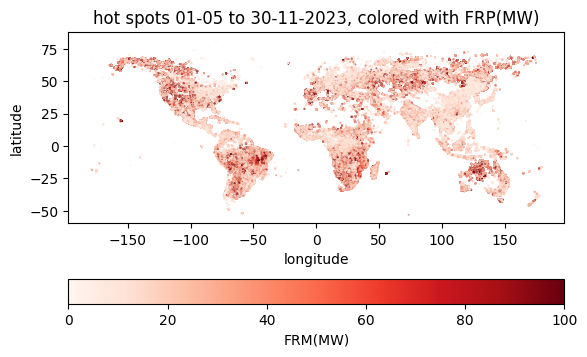

In [10]:
ax = plt.subplot(111)
hotspots.plot(markersize=0.1, alpha=.5, column='FRP', legend=True, cmap=mpl.cm.Reds, vmax=100, legend_kwds={
        "location":"bottom","label":"FRM(MW)"},ax=ax)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.title('hot spots 01-05 to 30-11-2023, colored with FRP(MW)')

The global impact of fire is quite straightforward. We do not need to plot the map to see the border contour.  

Let see now the gridded version provided by GFAS for the same period. As with FIRMS, data are on open access and can be retrieved from the Copernicus data server [here](
https://ads.atmosphere.copernicus.eu/datasets/cams-global-fire-emissions-gfas?tab=overview).

The daily FRP at 0.5 degree resolution is available for the same time period as above in the file `GFAS/GFAS-FRP-05to11-2023.nc`

In [11]:
frpgfas = xr.open_dataset(directory+'GFAS-FRP-2022-04_2022-09_05degree.nc')
frpgfas

<xarray.Dataset> Size: 379MB
Dimensions:    (time: 183, latitude: 360, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2022-04-02 2022-04-03 ... 2022-10-01
  * latitude   (latitude) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude  (longitude) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.3 359.8
Data variables:
    frpfire    (time, latitude, longitude) float64 379MB ...

you can see form the above print, that we have only one variable in this file: `frpfire`. If you click in the page icon at the end of the frpfire line, then you will see some info on the variable as its unit that is in W/m2.

In [12]:
#now to compute the sum of frpfire over the time period, therefore the FRE
fre = frpgfas['frpfire'].sum(dim='time').rename('fre') * 3600*24 # Fire Radiative Energy (J)/m2
fre.attrs['units'] = 'J/m2'
fre.attrs['timerange'] = [  pd.Timestamp(frpgfas['frpfire'].time[0].values),  pd.Timestamp(frpgfas['frpfire'].time[-1].values)]

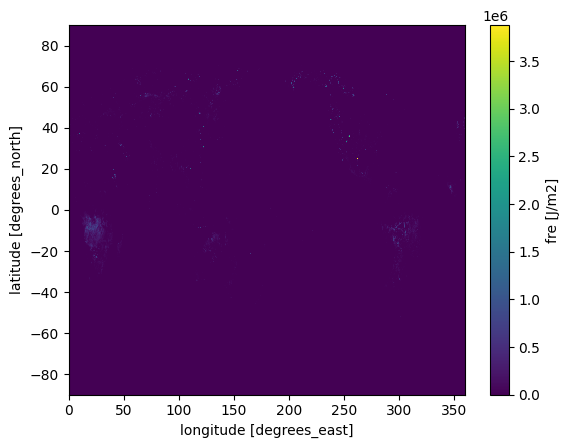

In [13]:
fre.plot()

The default ploting of FRE is not pertinent. We are going to apply a mask to mask out ocean using the dominant burning land cover map from above. However you can see from the info of the data array that`burninLC`and `fre` do not share the exact same coordinate. 
Therefore we are going first to interpolate `burninLC` on the same resolution than `fre` using a simple nearest interpolation (see `order=0` below).

In [14]:
#burninLC is overrwritten below
burninLC = burninLC.interp(longitude=fre['longitude'], latitude=fre['latitude'], method='nearest')

Text(0.5, 1.0, 'FRE over the time period  \n 2022-04-02 to 2022-10-01 (J/m2)')

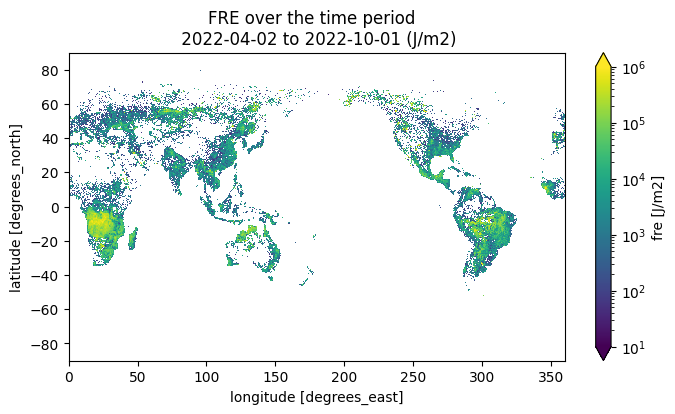

In [15]:
plt.figure(figsize=(8,4))
fre.where(burninLC!=0).plot(norm=mpl.colors.LogNorm(vmin=1.e1,vmax=1e6),cmap='viridis')
plt.title(f"FRE over the time period  \n {fre.timerange[0]:%Y-%m-%d} to {fre.timerange[-1]:%Y-%m-%d} (J/m2)")


this is better but we can still improve it.

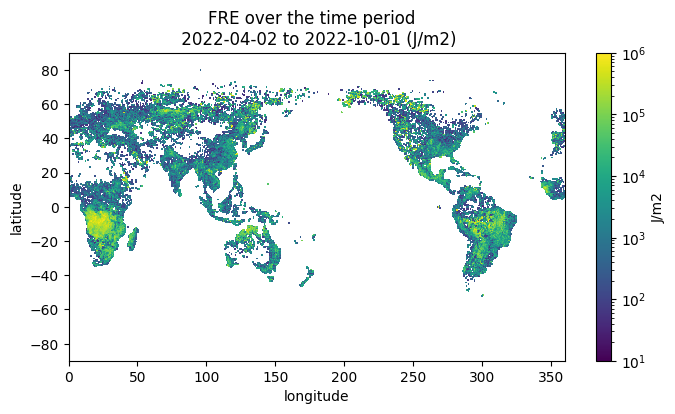

In [16]:
def plot_fre(fre,burninLC, ax=None, colorbarOrientation='vertical'):
    if ax is None:
        plt.figure(figsize=(8,4))
        ax = plt.subplot(111)
    
    c = ax.pcolor(fre['longitude'][:], fre['latitude'][:],
                      fre.where(burninLC.values!=0).values, 
                      norm=mpl.colors.LogNorm(vmin=1.e1,vmax=1e6) )
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude') 
    c.set_array(fre.where(burninLC.values!=0).values) # to avoid a futureWarning
    cbar = plt.colorbar(c,orientation=colorbarOrientation, label='J/m2') 
    ax.set_title(f"FRE over the time period  \n {fre.timerange[0]:%Y-%m-%d} to {fre.timerange[-1]:%Y-%m-%d} (J/m2)")
plot_fre(fre,burninLC)

The data in the two plots are the same, what change is the way the `plot` function from `dataArray` and `pcolor` from `matplotlib` are dealing with interpolation rendering. I used this example to show that using `matplotlib` function is slightly more powerful because more tunable. So if `dataArray.plot` is good for a first glance at your data, think to use `matplotlib.pcolor` for better rendering. i set it as a function to be able to reuse it later.

## 2. To go further

**Question>>** Are the hot-spots FRP and the gridded FRE maps showing the same spatial pattern?

**Answer>>**: No, see for example Africa between 0 an -10 latittude. The FRE is large while FRP hot-spots are higher further south or north to this same area. The reaseon is that FRE is the time integration of FRP, so that plotting FRP points does not give the same results as FRE. The frequence of fire matters. This particularly true in this savanna region of Africa.

### 2.1 select subset area for analysis

Here we are going to plot a zoom over west Europe with side by side the hot-spots and the gridded FRE for the month of july 2022, before looking at a possible correlation between fire number density end FRE.  
For this spatial subest (europe), we are going to use the 0.1 degree resolution data of `GFAS-FRP-2022-04_2022-09.nc`.

In [17]:
# Create a bounding box polygon
bbox = shapely.geometry.box(-10, 35, 40, 70) # Western Europe

In [18]:
#For the hot spot:
#############

# Clip the GeoDataFrame to the bounding box
clipped_hotspots = hotspots.clip(bbox)

#select time
clip_hs_july = clipped_hotspots[(clipped_hotspots['ACQ_DATE']>datetime.datetime(2022,7,1)) &
                                (clipped_hotspots['ACQ_DATE']<datetime.datetime(2022,8,1))]

In [19]:
#For the FRE:
#############
gfas = xr.open_dataset(directory+'GFAS-FRP-2022-04_2022-09.nc')
gfas = gfas.rename({"valid_time": "time"})

frpgfas=gfas.frpfire

#spatial clip 
#we need to shift the whole domain by 180 degre to move the area of interest in the middle for easier extraction.
frpgfas_rolled = frpgfas.roll(longitude=frpgfas.longitude.shape[0] // 2, roll_coords=True)
frpgfas_rolled.coords['longitude'] = ((frpgfas_rolled.coords['longitude'] + 180) % 360) - 180
frp_eu =frpgfas_rolled.sel(latitude=slice(bbox.bounds[3],bbox.bounds[1]), longitude=slice(bbox.bounds[0],bbox.bounds[2]) )
frpgfas = None # to free memory
gfas = None    # to free memory

timejulybeg = datetime.datetime(2022,7,1)
timejulyend = datetime.datetime(2022,8,1)
frp_eu_july = frp_eu.sel(time=slice(timejulybeg,timejulyend))

frp_eu = None


In [20]:
#compute fre for july. this is the time integration
fre_eu_july = frp_eu_july.sum(dim='time').rename('fre july') * 3600*24 # Fire Radiative Energy (J)/m2
fre_eu_july.attrs['units'] = 'J/m2'
fre_eu_july.attrs['timerange'] = [  pd.Timestamp(frp_eu_july.time[0].values),  pd.Timestamp(frp_eu_july.time[-1].values)]

In [21]:
#load burning LC that was rolled up to match frpgfas_rolled
burninLC_hd_rolled = xr.open_dataarray(directory+'GFED3_dominantBurningLC_version11112010_GAPFILLED.r3600x1800JUEL_EXTPEATOS_rolled_rp.nc')
burninLC_hd_eu =burninLC_hd_rolled.sel(latitude=slice(bbox.bounds[3],bbox.bounds[1]), longitude=slice(bbox.bounds[0],bbox.bounds[2]) )


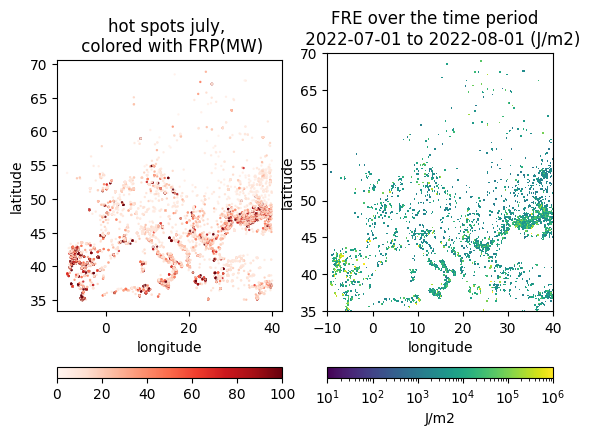

In [22]:
#plot side by side:
##################

ax = plt.subplot(121)
clip_hs_july.plot(markersize=0.5, alpha=.8, column='FRP', legend=True, cmap=mpl.cm.Reds, vmax=100, legend_kwds={
        "location":"bottom",},ax=ax)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.title('hot spots july, \n colored with FRP(MW)')

ax = plt.subplot(122)
plot_fre(fre_eu_july,burninLC_hd_eu, ax=ax,colorbarOrientation='horizontal')



**Question>>** show if there is any correlation between the number of fires and FRE? How does this help to answer the first question.

**Answer>>**:

In [23]:
gdf = clip_hs_july
coords = np.vstack([gdf.geometry.x, gdf.geometry.y])

# Perform Gaussian KDE on the coordinates
kde = gaussian_kde(coords)

# Create a grid over the area based on the bounding box of the points
x, y = np.meshgrid(fre_eu_july.longitude, fre_eu_july.latitude)
grid_coords = np.vstack([x.ravel(), y.ravel()])

# Evaluate the KDE on the grid points to get density values
z = kde(grid_coords).reshape((fre_eu_july.shape[0],fre_eu_july.shape[1]))

Text(0, 0.5, 'FRE (J/m2) - july 2022')

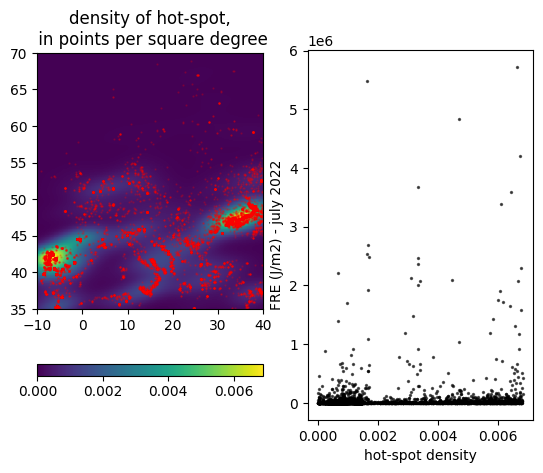

In [24]:
ax = plt.subplot(121)
im = ax.pcolor(fre_eu_july.longitude,fre_eu_july.latitude,z)
clip_hs_july.plot(markersize=0.5, alpha=.2, color='r',ax=ax)
ax.set_title('density of hot-spot,\n in points per square degree')
plt.colorbar(im,orientation='horizontal')

ax = plt.subplot(122)
idx_ = np.where(fre_eu_july.values>0)
ax.scatter(z[idx_], fre_eu_july.values[idx_], s=2, c='k', alpha=0.6)
ax.set_xlabel('hot-spot density')
ax.set_ylabel('FRE (J/m2) - july 2022')


The number of hot-spots does not correlate with the FRE. In other words, the number of fire does not follows the emission.This is cause by the variability of the FRP intensity that depends of fire behavior which is dependent of the burning landcover type and the season. 

### 2.2 Compute emission from one event

The fire of el pont de Vilomara took place at the location lat,lon = 41.702, 1.873 on the 17th of July 2022. Below we estimate the FRE for this fire and estimate the emission of CO2.

In [25]:
lat_pdv = 41.702
lon_pdv = 1.873
timejulybeg = datetime.datetime(2022,7,16)
timejulyend = datetime.datetime(2022,7,20)
bbox_cat = shapely.geometry.box(0, 38, 5 , 45) # cat

gfas = xr.open_dataset(directory+'GFAS-FRP-2022-04_2022-09.nc') # the 0.1 degree data
gfas = gfas.rename({"valid_time": "time"})
gfas['time'] = gfas.time - pd.Timedelta(days=1) # to have it back to start of the time period
frpgfas=gfas.frpfire

frp_pdV = frpgfas.sel(time=slice(timejulybeg,timejulyend))
frp_pdV = frp_pdV.sel(latitude=slice(bbox_cat.bounds[3],bbox_cat.bounds[1]), longitude=slice(bbox_cat.bounds[0],bbox_cat.bounds[2]) )

fre_pdV = frp_pdV.rename('fre pdV') * 24*3600 # daily Fire Radiative Energy (J)/m2 per day
fre_pdV.attrs['units'] = 'J/m2 per day'
fre_pdV.attrs['timerange'] = [  pd.Timestamp(frp_pdV.time[0].values),  pd.Timestamp(frp_pdV.time[-1].values)]
 
fre_pdV_1px = fre_pdV.sel(longitude=lon_pdv, latitude=lat_pdv, method='nearest') 
#this is the daily FRE at the pixel nearest to (lon_pdv,lat_pdv)

#get also the i and j location of our point of interest
i_lon = np.where(fre_pdV.coords['longitude'] == fre_pdV_1px.longitude)
j_lat = np.where(fre_pdV.coords['latitude'] == fre_pdV_1px.latitude)

frpgfas = None   # free memory
print( 'working with array that are', frp_pdV.shape)

working with array that are (5, 70, 50)


In [26]:
#load burning LC that was rolled up to match frpgfas_rolled
burninLC_hd =  burninLC.interp(longitude=fre_pdV['longitude'], latitude=fre_pdV['latitude'], method='nearest')
burninLC_hd_pdV =burninLC_hd.sel(latitude=slice(bbox_cat.bounds[3],bbox_cat.bounds[1]), longitude=slice(bbox_cat.bounds[0],bbox_cat.bounds[2]) )
burninLC_hd_pdV = burninLC_hd_pdV.interp(longitude=fre_pdV.longitude, latitude=fre_pdV.latitude, method='nearest')


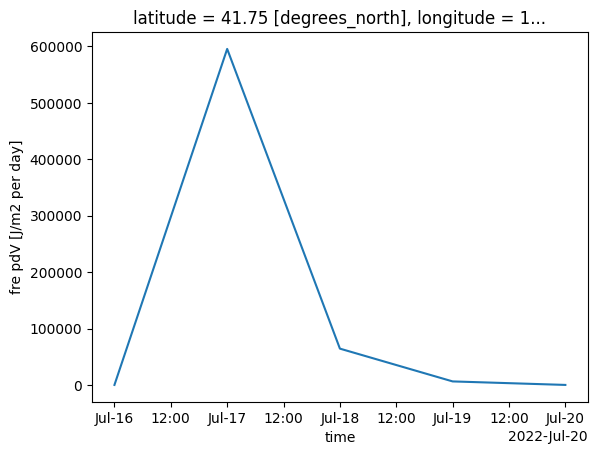

In [27]:
fre_pdV_1px.plot()

This is the time serie of FRE from only one pixel. However at this stage we don't know if the fire was only included in one GFAS pixel or was larger. So we need to investigate if we have cluster of fire pixel at each time step.

In [28]:
#compute timely mask so that we are not only considering one pixel but the fire cluster if it exists
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]
print('fire size in pixels:')
mask3d = np.zeros(fre_pdV.shape)
for it in range(fre_pdV.time.shape[0]):
    fre_pdvt = fre_pdV.data[it]
    labeled, num_features = scipy.ndimage.label(np.where(fre_pdvt>0,1,0), structure=s)    
    label = labeled[j_lat,i_lon]
    if label != 0:
        mask3d[it,:,:] = np.where(labeled==label, 1, 0) 
    print(fre_pdV.time[it].values, np.where(mask3d[it]==1)[0].shape[0])


fire size in pixels:
2022-07-16T00:00:00.000000000 0
2022-07-17T00:00:00.000000000 4
2022-07-18T00:00:00.000000000 4
2022-07-19T00:00:00.000000000 3
2022-07-20T00:00:00.000000000 0


In [29]:
#get array of conversion factor from burninLC_hd
#latitudeLC = landCover.variables['lat'][:]
#longitudeLC = landCover.variables['lon'][:]

CF = np.zeros_like(mask3d)
dtype = 'U10'   # Data type, where 'U10' means Unicode string with max length 10
fuelType = np.full(mask3d.shape, '', dtype=dtype)
LC = np.full(mask3d.shape, '', dtype=dtype)

#for it in range(len(idx_timepdv[0])):
for it in range(fre_pdV.time.shape[0]):
    print(fre_pdV.time[it].values)
    for i,j in zip(*np.where(mask3d[it]==1)):
        latpx = fre_pdV.latitude[i]  #mask3d is build on fre_pdV (see box above)
        lonpx = fre_pdV.longitude[j]
        #idx_latLC = 5*np.abs(latitudeLC[::-1] - latpx).argmin()  # x5 because of the zoom
        #idx_lonLC = 5*np.abs(longitudeLC - lonpx).argmin()
        print(latpx.values,lonpx.values, burninLC_hd_pdV.sel(latitude=latpx.values, longitude=lonpx.values, method='nearest').values)
        CF[it,i,j] = LCidx.loc[int(burninLC_hd_pdV.sel(latitude=latpx, longitude=lonpx, method='nearest'))]['conv_factor'] # kg/MJ
        LC[it,i,j] = LCidx.loc[int(burninLC_hd_pdV.sel(latitude=latpx, longitude=lonpx, method='nearest'))]['land_cover']
        fuelType[it,i,j] = LCidx.loc[int(burninLC_hd_pdV.sel(latitude=latpx, longitude=lonpx, method='nearest'))]['fuel_type'].strip()

        print( 'burning Land cover is : {:s}, "{:s}"'.format( LC[it,i,j], fuelType[it,i,j] ) )
        print( 'conversion factor is : {:2f}'.format( CF[it,i,j] ) )
    print('----')
#convert to da
CF = xr.DataArray( CF, dims=fre_pdV.dims, 
                   coords={"time":fre_pdV['time'], "latitude": fre_pdV['latitude'], "longitude": fre_pdV['longitude']},
                   name="conversion Factor")
                  

2022-07-16T00:00:00.000000000
----
2022-07-17T00:00:00.000000000
41.75000000000116 1.8500000000000005 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.75000000000116 1.9500000000000006 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.65000000000116 1.8500000000000005 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.65000000000116 1.9500000000000006 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
----
2022-07-18T00:00:00.000000000
41.75000000000116 1.8500000000000005 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.75000000000116 1.9500000000000006 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.65000000000116 1.8500000000000005 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
41.65000000000116 1.9500000000000006 1.0
burning Land cover is : savannah, "SA"
conversion factor is : 0.780000
----

get pixel size using [haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)

In [30]:
#compute pixelArea for the points where we have fre value
#pixel aera is in km2
importlib.reload(haversine2Da)
pixelArea = haversine2Da.compute_pixel_area(fre_pdV, mask=np.where(mask3d.sum(axis=0)>0,1,0))

In [31]:
#compute map of CO2 emission factor
EF_CO2 = np.zeros_like(CF)

for it in range(fre_pdV.time.shape[0]):
    for i,j in zip(*np.where(mask3d[it]==1)):
        EF_CO2[it,i,j] = data_EF[data_EF['Species']=='CO2'][fuelType[it,i,j]].iloc[0] 
#convert to da
EF_CO2 = xr.DataArray( EF_CO2, dims=fre_pdV.dims, 
                       coords={"time":fre_pdV['time'], "latitude": fre_pdV['latitude'], "longitude": fre_pdV['longitude']},
                       name="Emission Factor")    

In [32]:
FRE_pdv = (fre_pdV.where((pixelArea>0)&(fre_pdV>0)) * pixelArea.where((pixelArea>0)&(fre_pdV>0))).sum()   * 1.e-6# MJ

In [33]:
DM_pdv = ( fre_pdV.where((pixelArea>0)&(fre_pdV>0)) * 1.e-6 * 
           CF.where((pixelArea>0)&(fre_pdV>0)) * 
           pixelArea.where((pixelArea>0)&(fre_pdV>0)) 
         ).sum() * 1.e-3 # ton of Dry Mass burn

In [34]:
E_CO2_pdv = ( fre_pdV.where((pixelArea>0)&(fre_pdV>0)) * 1.e-6 *
              CF.where((pixelArea>0)&(fre_pdV>0)) * 
              EF_CO2.where((pixelArea>0)&(fre_pdV>0))  * 
              pixelArea.where((pixelArea>0)&(fre_pdV>0)) 
            ).sum()            * 1.e-6# ton

In [35]:
print('total FRE   = {:.3e} MJ'.format(FRE_pdv))
print('total DM    = {:.3f} ton'.format(DM_pdv))
print('total E_CO2 = {:.3f} ton'.format(E_CO2_pdv))


total FRE   = 1.049e+08 MJ
total DM    = 81822.322 ton
total E_CO2 = 134679.542 ton


In [36]:
#For Validation
###############
#load CO2 emission as directly compuyted in GFAS
# another file is present in the same directory where more than the FRP is available
gfas = xr.open_dataset(directory+'GFAS-FRP-05to11-2023_gas_FRP_hbltop.nc')
# this file does not need the time correction 

timejulybeg = datetime.datetime(2022,7,16)
timejulyend = datetime.datetime(2022,7,20)

gfas_pdV = gfas.sel(time=slice(timejulybeg,timejulyend))
gfas_pdV = gfas_pdV.sel(latitude=slice(bbox_cat.bounds[3],bbox_cat.bounds[1]), longitude=slice(bbox_cat.bounds[0],bbox_cat.bounds[2]) )
gfas_pdV


<xarray.Dataset> Size: 561kB
Dimensions:    (longitude: 50, latitude: 70, time: 5)
Coordinates:
  * longitude  (longitude) float32 200B 0.05 0.15 0.25 0.35 ... 4.75 4.85 4.95
  * latitude   (latitude) float32 280B 44.95 44.85 44.75 ... 38.25 38.15 38.05
  * time       (time) datetime64[ns] 40B 2022-07-16 2022-07-17 ... 2022-07-20
Data variables:
    apt        (time, latitude, longitude) float64 140kB ...
    co2fire    (time, latitude, longitude) float64 140kB ...
    cofire     (time, latitude, longitude) float64 140kB ...
    frpfire    (time, latitude, longitude) float64 140kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-24 18:19:22 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

gfas_pdV as the same coordinate and same dimension (5,120,100) as frp_pdV, therefore we can apply the same mask

In [37]:
pixelArea_gfas_pdV = haversine2Da.compute_pixel_area(gfas_pdV.frpfire, mask=np.where(mask3d.sum(axis=0)>0,1,0))


In [38]:
FRE_val = (gfas_pdV['frpfire'].where((pixelArea_gfas_pdV>0)&(gfas_pdV['frpfire']>0)) *pixelArea_gfas_pdV.where((pixelArea_gfas_pdV>0)&(gfas_pdV['frpfire']>0)) * 24 *3600).sum() * 1.e-6 # MJ
E_CO2_val = (gfas_pdV['co2fire'].where((pixelArea_gfas_pdV>0)&(gfas_pdV['frpfire']>0)) *pixelArea_gfas_pdV.where((pixelArea_gfas_pdV>0)&(gfas_pdV['frpfire']>0)) * 24 *3600).sum() * 1.e-3 # Ton

In [39]:
print('total FRE   Val = {:.3e} MJ'.format(FRE_val))
print('total E_CO2 Val = {:.3f} ton'.format(E_CO2_val))

total FRE   Val = 1.049e+08 MJ
total E_CO2 Val = 127993.639 ton


Difference in CO2 emission is probably due to update Emission Factor and/or land cover map. We use here the ones from 2012.

**Question>>** Using the code above can you estimate CO emission?

**Answer>>**

In [40]:
#compute map of CO emission factor using the first calculation based on EF 
EF_CO = np.zeros_like(CF)

for it in range(fre_pdV.time.shape[0]):
    for i,j in zip(*np.where(mask3d[it]==1)):
        EF_CO[it,i,j] = data_EF[data_EF['Species']=='CO'][fuelType[it,i,j]].iloc[0] 
#convert to da
EF_CO = xr.DataArray( EF_CO, dims=fre_pdV.dims, 
                       coords={"time":fre_pdV['time'], "latitude": fre_pdV['latitude'], "longitude": fre_pdV['longitude']},
                       name="Emission Factor") 


In [41]:
E_CO_pdv = ( fre_pdV.where((pixelArea>0)&(fre_pdV>0)) * 1.e-6 *
              CF.where((pixelArea>0)&(fre_pdV>0)) * 
              EF_CO.where((pixelArea>0)&(fre_pdV>0))  * 
              pixelArea.where((pixelArea>0)&(fre_pdV>0)) 
            ).sum()            * 1.e-6# ton


In [42]:
print('total E_CO = {:.3f} ton'.format(E_CO_pdv))

total E_CO = 4991.162 ton


## 3. To deliver

### 3.1 plot FRE map for the time period Octobre 2022 to Mars 2023.

**Question>>:** Plot for the two time periods Avril 2022 to Septembre 2022 and Octobre 2022 to Mars 2023 the global map of FRE. Iterpret thoses plots using your knwoledge  on fire seasons.    
There is available in the data diretory the file `GFAS-FRP-2022-10_2023-03.nc` that you can you use for this task. As the other file, it comes from the [CAMS server](https://ads.atmosphere.copernicus.eu/datasets/cams-global-fire-emissions-gfas?tab=overview).

**Answer>>:** 

### 3.2 Compute emission from an area

**Question>>:** Can you estimate the contribution of the fire of el pont de Vilomara to the total burn mass of cataluna over the time period may to nov 2022? A shape file of the province boundaries for all world countries is available at `FBM_unit05/Emission/GFAS/earth-admin1.gpkg`

cataluna border can be extracted following:

In [45]:
cat = gpd.read_file(directory+'earth-admin1.gpkg')
cat = cat[cat['region']=='Cataluña'].dissolve() # to merge all provinces of cataluna

**tips**: for raster mask computation from vector data see example [here](https://github.com/3dfirelab/python-intro-course/blob/master/05c-GIS-vector2raster.ipynb))

**Answer>>:**